# Fake News with G-ZIP

In [2]:
# Data libraries
import numpy as np
import pandas as pd

# Text preprocessing libraries
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# GZIP libraries
import gzip
from tqdm import tqdm
from collections import Counter

# Visualization libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. Data Preparation

## 1.1 Load and process dataset

In [3]:
def process_data(path):
    data = pd.read_json(train_json, lines=True)

    # de tokenize
    data["text"] = data["Text"].apply(lambda x: "".join(x))
    data.drop("Text", axis=1, inplace=True)
    data.rename(columns={"Document Tag": "intent"}, inplace=True)
    return data

In [4]:
train_json = "https://raw.githubusercontent.com/byinth/LimeSoda/main/dataset_train_wo_tokentags_v1/train_v1.jsonl"
test_json = "https://raw.githubusercontent.com/byinth/LimeSoda/main/dataset_train_wo_tokentags_v1/test_v1.jsonl"

df_train = process_data(train_json)
df_test = process_data(test_json)

### 1.2 Create a dictionary of labels

In [5]:
uniq = list(set(df_train["intent"].values))
labels = {j:i for i,j in zip(range(len(uniq)), uniq)}
labels

{'Fact News': 0, 'Fake News': 1}

In [6]:
df_train["label"] = df_train["intent"].apply(lambda x: labels[x])
df_test["label"] = df_test["intent"].apply(lambda x: labels[x])

## G-ZIP Original Paper Implementation

In [8]:
k = 2
predicted_classes = []

for row_test in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    test_text = row_test[1]["text"]
    test_label = row_test[1]["label"]
    c_test_text = len(gzip.compress(test_text.encode()))
    distance_from_test_instance = []

    for row_train in df_train.iterrows():
        train_text = row_train[1]["text"]
        train_label = row_train[1]["label"]
        c_train_text = len(gzip.compress(train_text.encode()))
        train_plus_test = " ".join([test_text, train_text])
        c_train_plus_test = len(gzip.compress(train_plus_test.encode()))

        ncd = ((c_train_plus_test - min(c_train_text, c_test_text))
                / max(c_test_text, c_train_text))
        distance_from_test_instance.append(ncd)

    sorted_idx = np.argsort(np.array(distance_from_test_instance))
    top_k_class = df_train.iloc[sorted_idx[:k]]["label"].values
    predicted_class = np.argmax(np.bincount(top_k_class))
    predicted_classes.append(predicted_class)

print("Accuracy:", np.mean(np.array(predicted_classes) == df_test["label"].values))

100%|██████████| 2698/2698 [2:55:39<00:00,  3.91s/it]

Accuracy: 0.9321719792438844


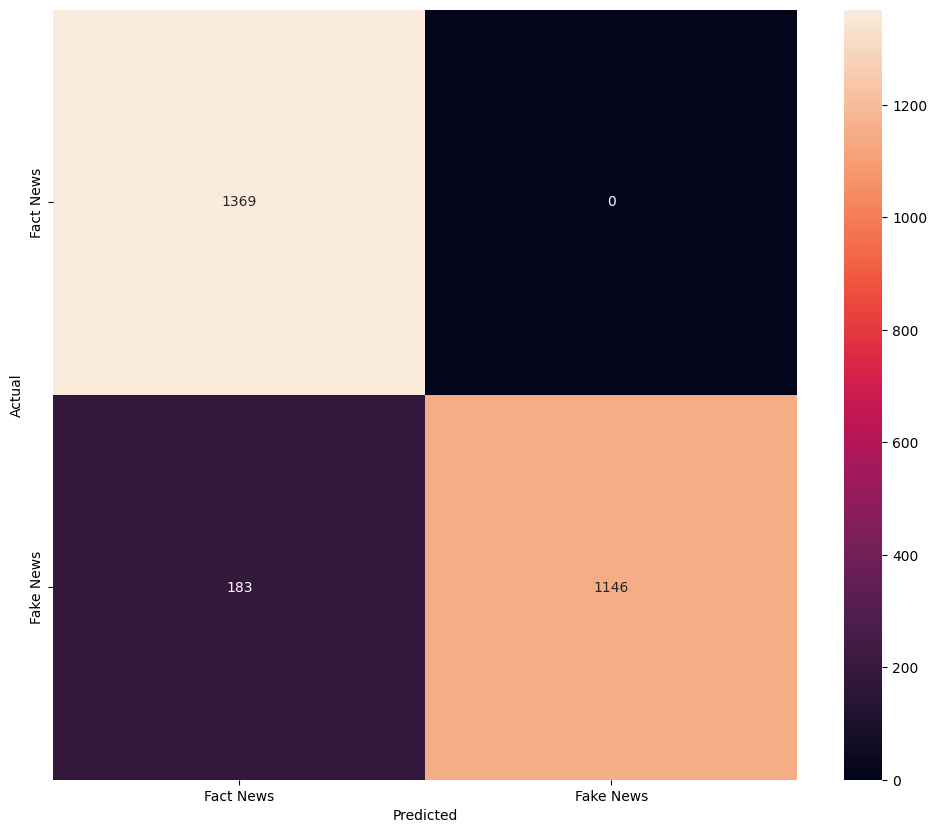

In [9]:
cm = confusion_matrix(df_test["label"].values, np.array(predicted_classes))
# plot with seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=uniq, yticklabels=uniq)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## G-ZIP With Tie-Breaking Fix

In [10]:
k = 2
predicted_classes = []

for row_test in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    test_text = row_test[1]["text"]
    test_label = row_test[1]["label"]
    c_test_text = len(gzip.compress(test_text.encode()))
    distance_from_test_instance = []

    for row_train in df_train.iterrows():
        train_text = row_train[1]["text"]
        train_label = row_train[1]["label"]
        c_train_text = len(gzip.compress(train_text.encode()))

        train_plus_test = " ".join([test_text, train_text])
        c_train_plus_test = len(gzip.compress(train_plus_test.encode()))

        ncd = ( (c_train_plus_test - min(c_train_text, c_test_text))
                / max(c_test_text, c_train_text) )
        distance_from_test_instance.append(ncd)

    sorted_idx = np.argsort(np.array(distance_from_test_instance))
    top_k_class = np.array(df_train["label"])[sorted_idx[:k]]
    predicted_class = Counter(top_k_class).most_common()[0][0]
    predicted_classes.append(predicted_class)

print("Accuracy:", np.mean(np.array(predicted_classes) == df_test["label"].values))

100%|██████████| 2698/2698 [2:55:49<00:00,  3.91s/it]

Accuracy: 0.9992587101556709


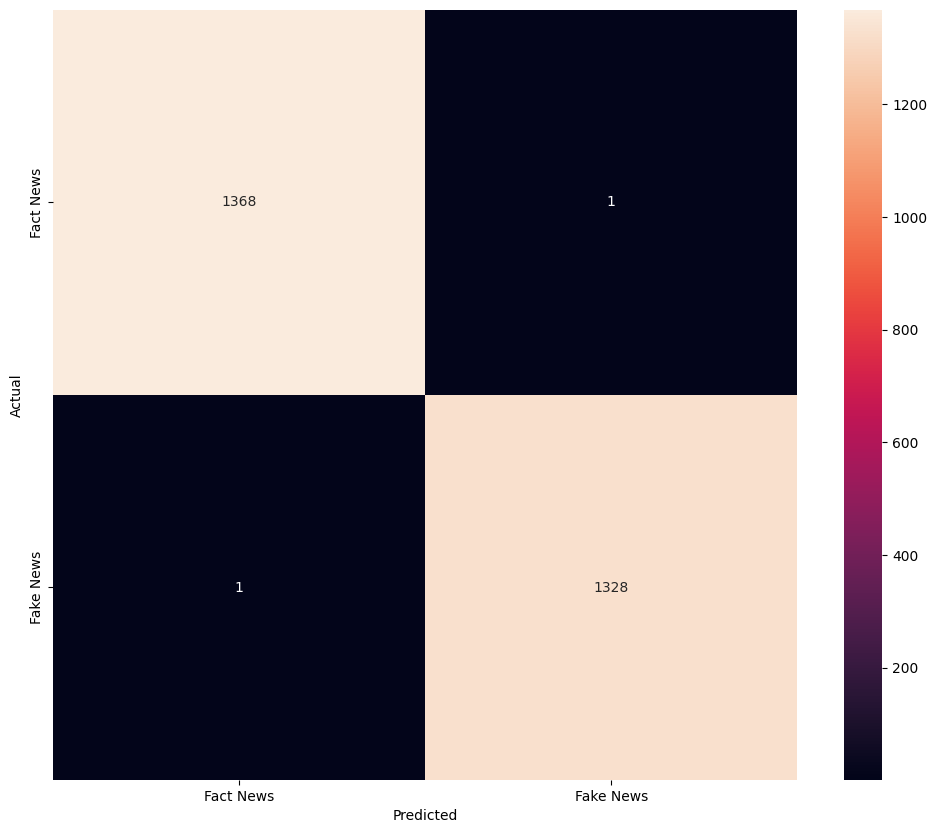

In [11]:
cm = confusion_matrix(df_test["label"].values, np.array(predicted_classes))
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=uniq, yticklabels=uniq)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [15]:
# give me sample of unmatched predictions
df_test["predicted"] = predicted_classes
df_test["predicted"] = df_test["predicted"].apply(lambda x: uniq[x])
df_test[df_test["intent"] != df_test["predicted"]]

,intent,text,label,predicted
332,Fake News,กินร้อนช้อนกลางล้างมือ!!สพฐ.กำชับโรงเรียนดูแลเ...,1,Fact News
537,Fact News,สุดยอดแพทย์ไทยใช้ยาต้านไวรัสไข้หวัดใหญ่และยาต้...,0,Fake News
